**1 - LOAD PACKAGES**



*   [numpy](https://numpy.org/) is the fundamental package for scientific computing with Python.
*   [matplotlib](https://matplotlib.org/) is a library for plotting graphs in Python.
*   [pandas](https://pandas.pydata.org/) is used for data manipulation and analysis
*   [sklearn](https://scikit-learn.org/stable/) is used for data mining and data analysis using simple functions
*   [collections](https://docs.python.org/3/library/collections.html) is a library which implements operations on specialized container datatypes





In [1]:
#Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing, model_selection
from sklearn.metrics import confusion_matrix
import itertools
from collections import Counter
import collections
from imblearn.over_sampling import RandomOverSampler


**2 - LOADING THE DATA**

In [2]:
#Reading the data
with open('train.dat','r') as f:
    train = f.readlines()

with open('test.dat','r') as f:
    test = f.readlines()

**3 - UNDERSTANDING THE DATA**

In [3]:
#Splitting the data by tab
ytr = [int(p.split('\t')[0]) for p in train]
tr = [p.split('\t')[1].strip() for p in train]
tr_label = [p.split('\t')[0].strip() for p in train]
tr_label = np.array(tr_label).astype(int)

# te = [int(p.split('\t')[0]) for p in test]
te = [p.strip() for p in test]

In [4]:
len_train = len(train)
len_test = len(test)
label_count = Counter(tr_label)

print (f'The shape of train data is: ',  len_train)
print (f'The shape of test data is: ', len_test)
print (f'Label count: ', label_count)

The shape of train data is:  1566
The shape of test data is:  392
Label count:  Counter({-1: 1424, 1: 142})


**4 - PREPROCESSING THE DATA**

Feature exraction has been done using the k-mers model and obersampling has been done using RandomOverSampler in-built function of imblearn library in python.

**4.1 - Extracting character sequences using k-mers**

In [5]:
#k mers generates all possible substrings of length k
def kmer(p, k =2):
  return [p[i:i+k] for i in range(0,len(p) - k+1)]

def kmers(p, k =2):
  els = []
  for i in range(1,k):
    els.extend(kmer(p, k =i))
  return els

tr = [kmers(p, k=3) for p in tr]
te = [kmers(p, k=3) for p in te]

mp = {}
for p in tr+te:
  for e in p:
    if e not in mp:
      mp[e] = len(mp.keys()) #assigning it the length of the dictionary
len(mp)

436

In [6]:
#Making a dense matrix
def dense(ds):
  op = []
  for p in ds:
    res = [0] * len(mp)
    count = dict(collections.Counter(p))
    for k in count:
      res[mp[k]] = count[k]
    op.append(res)
  return np.array(op)

In [7]:
dense_mat_train = dense(tr)
dense_mat_test = dense(te)

In [8]:
print(Counter(tr_label))

Counter({-1: 1424, 1: 142})


**4.2 - Oversampling to balance the data**

In [9]:
# Doing oversampling to balance the imbalanced classes
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
train_bal_df, train_bal_y = oversampler.fit_resample(dense_mat_train, tr_label)

In [10]:
print(Counter(train_bal_y))

Counter({-1: 1424, 1: 1424})


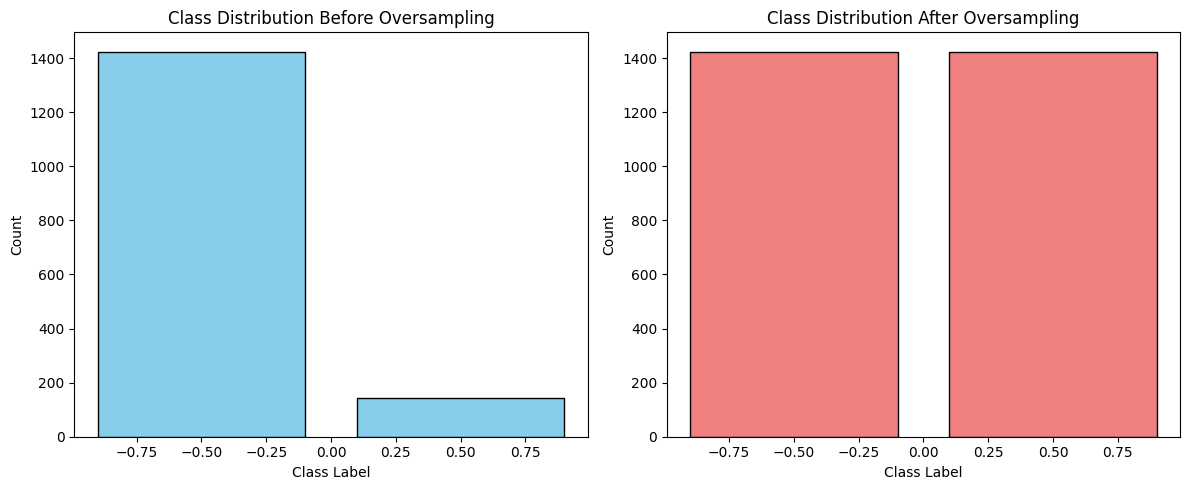

In [11]:
# Plotting class distribution before oversampling
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(tr_label, bins = (-1,0,1), rwidth=0.8, color='skyblue', edgecolor='black')
plt.title('Class Distribution Before Oversampling')
plt.xlabel('Class Label')
plt.ylabel('Count')

# Plotting class distribution after oversampling
plt.subplot(1, 2, 2)
plt.hist(train_bal_y, bins = (-1,0,1), rwidth=0.8, color='lightcoral', edgecolor='black')
plt.title('Class Distribution After Oversampling')
plt.xlabel('Class Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

**4.3 - Splitting data into train and validations sets to start training**

In [26]:
#dividing data into training and test so that we can have lo
train_x, val_x, train_y, val_y = model_selection.train_test_split(train_bal_df, train_bal_y, test_size=0.25, random_state=1)

In [27]:
train_x = np.array(train_x).T
train_y = (np.array(train_y).astype(int) + 1)/2 #Mapping -1 labels to zero to handle labeling
train_y = train_y.reshape(-1,1)

val_x = np.array(val_x).T
val_y = (np.array(val_y).astype(int) + 1)/2 #Mapping -1 labels to zero to handle labeling
val_y = val_y.reshape(-1,1)

**5 - NEURAL NETWORK MODEL ARCHITECTURE**

**5.1 - Defining Activation Functions and Derivatives**

In [28]:
#ReLU Activation Function
def relu(x):
    return np.maximum(0, x)

#Sigmoid Activation Function
def sigmoid(x):
    return 1/(1+np.exp(-x))

def dRelu2(x, y):
    x[Y <= 0] = 0
    return x

#Sigmoid Derivative
def sigmoid_derivative(x):
    s = 1/(1+np.exp(-x))
    y = s * (1-s)
    return y

#ReLU Derivative
def relu_derivative(x):
    return np.where(x <= 0, 0, 1)

Basic structure of a single hidden layer neural network model built in this code:

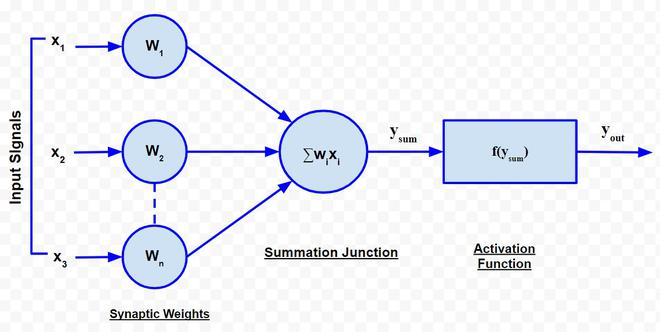

**5.2 - Building the Neural Network using NumPy**

In [31]:
# Initializing the parameters
def initialize_parameters(dims):
    np.random.seed(1)
    param = {}
    param['W1'] = np.random.randn(dims[1], dims[0]) / np.sqrt(dims[0])
    param['b1'] = np.zeros((dims[1], 1))
    param['W2'] = np.random.randn(dims[2], dims[1]) / np.sqrt(dims[1])
    param['b2'] = np.zeros((dims[2], 1))
    return param

# Forward pass
def forward(X, param):
    Z1 = param['W1'].dot(X) + param['b1']
    A1 = relu(Z1)

    Z2 = param['W2'].dot(A1) + param['b2']
    A2 = sigmoid(Z2)

    return A2, A1, Z2, Z1

# Loss function
def loss(Y, Yh):
    loss = (1./Y.shape[1]) * (-np.dot(Y, np.log(Yh).T) - np.dot(1-Y, np.log(1-Yh).T))
    return loss

# Backward pass
def backward(X, Y, A2, A1, Z2, Z1, param, lr):
    dLoss_Yh = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
    dLoss_Z2 = dLoss_Yh * sigmoid_derivative(Z2)
    dLoss_A1 = np.dot(param["W2"].T, dLoss_Z2)

    dLoss_W2 = 1./A1.shape[1] * np.dot(dLoss_Z2, A1.T)
    dLoss_b2 = 1./A1.shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1]))

    dLoss_Z1 = dLoss_A1 * (Z1 > 0)
    dLoss_W1 = 1./X.shape[1] * np.dot(dLoss_Z1, X.T)
    dLoss_b1 = 1./X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))

    param["W1"] = param["W1"] - lr * dLoss_W1
    param["b1"] = param["b1"] - lr * dLoss_b1
    param["W2"] = param["W2"] - lr * dLoss_W2
    param["b2"] = param["b2"] - lr * dLoss_b2

    return param

# Defining the Gradient Descent function
def gd(X, Y, dims, lr, iter = 3000):
    param = initialize_parameters(dims)
    loss_recorded = []

    for i in range(iter):
        Yh, A1, Z2, Z1 = forward(X, param)
        param = backward(X, Y, Yh, A1, Z2, Z1, param, lr)

        if i % 100 == 0:
            l = loss(Y, Yh)
            print(f"Loss after iteration {i}: {l}")
            loss_recorded.append(l)

    return param, loss_recorded

# Making predictions
def predict(x, param, threshold=0.7):
    A2, _, _, _ = forward(x, param)
    comp = np.zeros((1, x.shape[1]))
    for i in range(A2.shape[1]):
        if A2[0, i] > threshold:
            comp[0, i] = 1
        else:
            comp[0, i] = 0
    return comp

**5.3 - Defining the hyperparameters and training the model**

In [32]:
#Setting the dimensions of input, hidden and output layer
dims = [436, 200, 1]
#Setting the learning rate
learning_rate = 0.07

# Training the model
trained_params, loss_train = gd(train_x, train_y.T, dims, learning_rate)
val_params, loss_val = gd(val_x, val_y.T, dims, learning_rate)

# Making predictions on validation data
predictions = predict(val_x, val_params)

Loss after iteration 0: [[0.71814129]]
Loss after iteration 100: [[0.16242361]]
Loss after iteration 200: [[0.11248914]]
Loss after iteration 300: [[0.08488771]]
Loss after iteration 400: [[0.06644812]]
Loss after iteration 500: [[0.05336921]]
Loss after iteration 600: [[0.0437167]]
Loss after iteration 700: [[0.03630561]]
Loss after iteration 800: [[0.03050114]]
Loss after iteration 900: [[0.02596544]]
Loss after iteration 1000: [[0.0224004]]
Loss after iteration 1100: [[0.0195446]]
Loss after iteration 1200: [[0.01720288]]
Loss after iteration 1300: [[0.01526803]]
Loss after iteration 1400: [[0.01365572]]
Loss after iteration 1500: [[0.01229512]]
Loss after iteration 1600: [[0.01113783]]
Loss after iteration 1700: [[0.01014542]]
Loss after iteration 1800: [[0.00928893]]
Loss after iteration 1900: [[0.00854519]]
Loss after iteration 2000: [[0.00789506]]
Loss after iteration 2100: [[0.00732341]]
Loss after iteration 2200: [[0.00681722]]
Loss after iteration 2300: [[0.00636681]]
Loss af

In [33]:
#Calculating the accuracy
diff = np.mean(predictions == val_y)
print(diff*100)

50.00355068804444


**6 - MODEL EVALUATION**

**6.1 - Checking the loss curve for train and validation data**

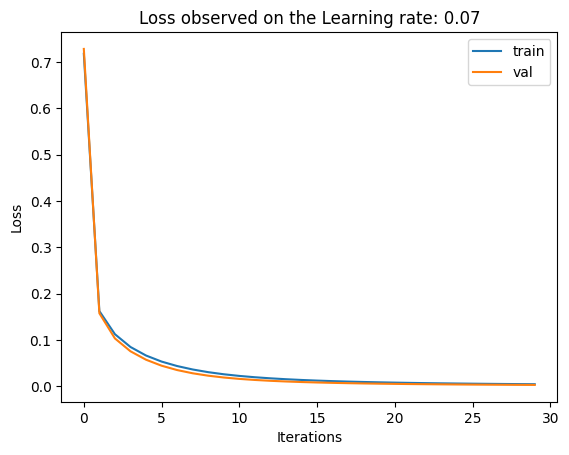

In [35]:
#Plotting the curve for loss rate observed in train and validation data
plt.plot(np.squeeze(loss_train), label = 'train')
plt.plot(np.squeeze(loss_val), label = 'val')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title(f"Loss observed on the Learning rate: {learning_rate}")
plt.legend()
plt.show()

In [36]:
t_p, l = gd(train_x, train_y.T, dims, lr = 0.005, iter = 600)

Loss after iteration 0: [[0.71814129]]
Loss after iteration 100: [[0.49993776]]
Loss after iteration 200: [[0.38687895]]
Loss after iteration 300: [[0.32166099]]
Loss after iteration 400: [[0.28157461]]
Loss after iteration 500: [[0.25476938]]


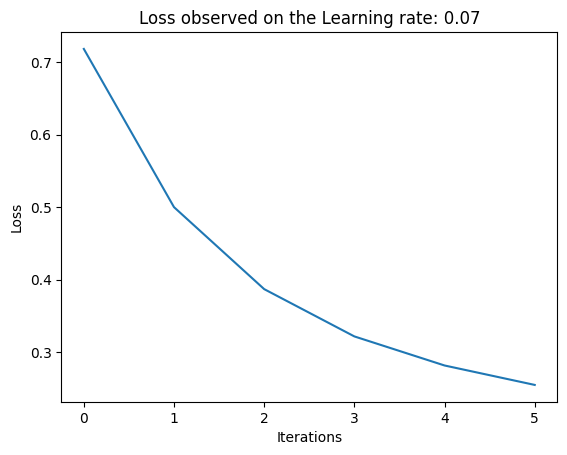

In [37]:
#Plotting the curve for loss rate observed in train and test data
plt.plot(np.squeeze(l))
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title(f"Loss observed on the Learning rate: {learning_rate}")
plt.show()

**6.2 - Building a Confusion Matrix**

A confusion matrix will help in understanding how many instances of both the classes are getting correctly or incorrectly predicted.

In [38]:
def plotCf(a,b,t):
    cf = confusion_matrix(a, b)
    plt.imshow(cf, cmap = plt.cm.Blues, interpolation = 'nearest')
    plt.colorbar()
    plt.title(t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(a))) # length of classes
    class_labels = ['0','1']
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j, i, format(cf[i,j],'d'), horizontalalignment = 'center', color = 'white' if cf[i,j] >thresh else 'black')
    plt.show()

<ipython-input-39-369e5062509a>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target = np.around(np.squeeze(train_y), decimals = 0).astype(np.int)
<ipython-input-39-369e5062509a>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informatio

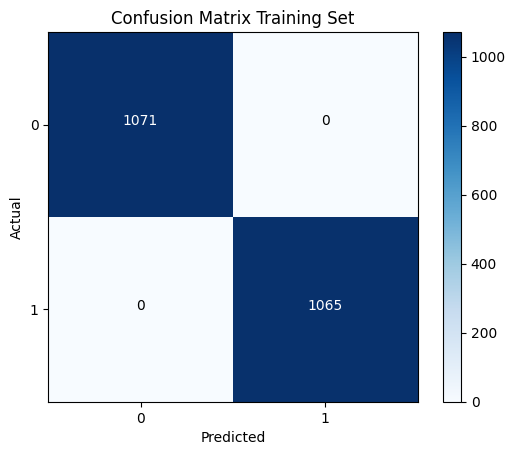

<ipython-input-39-369e5062509a>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target = np.around(np.squeeze(val_y), decimals = 0).astype(np.int)
<ipython-input-39-369e5062509a>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.

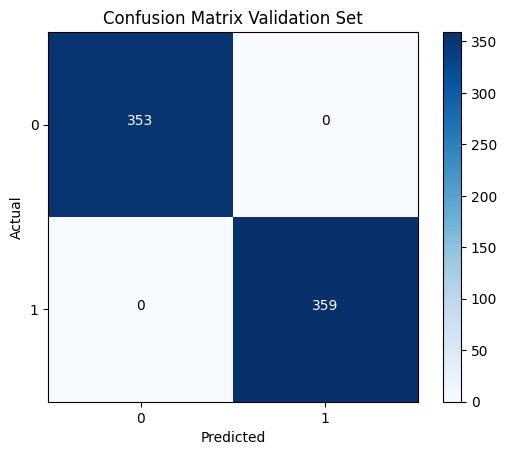

In [39]:
X, Y = train_x, train_y
target = np.around(np.squeeze(train_y), decimals = 0).astype(np.int)
predicted = np.around(np.squeeze(predict(train_x, trained_params)), decimals = 0).astype(np.int)
plotCf(target, predicted, 'Confusion Matrix Training Set')

X, Y = val_x, val_y
target = np.around(np.squeeze(val_y), decimals = 0).astype(np.int)
predicted = np.around(np.squeeze(predict(val_x, val_params)), decimals = 0).astype(np.int)
plotCf(target, predicted, 'Confusion Matrix Validation Set')

**7 - MAKING PREDICTIONS FOR THE TEST FILE**

In [40]:
predictions_test = predict(dense_mat_test.T, trained_params)
predictions_test = np.where(predictions_test == 0, -1, predictions_test)

In [41]:
predictions_test = predictions_test.T
predictions_test = predictions_test.astype(int)

In [42]:
  with open('/content/test.txt','w+') as file:
      for i in predictions_test:
          file.write("%s\n" % int(i))